# Exercise 2: Decision Trees

In this assignment you will implement a Decision Tree algorithm as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw1_123456789_987654321.ipynb` if you submitted in pairs and `hw1_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Practice OOP in python.
2. Implement two impurity measures: Gini and Entropy.
3. Construct a decision tree algorithm.
4. Prune the tree to achieve better results.
5. Visualize your results.

# I have read and understood the instructions: *** 205894579 , 206093114  ***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Warmup - OOP in python

Our desicion tree will be implemented using a dedicated python class. Python classes are very similar to classes in Java.


You can use the following [site](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/) to learn about classes in python.

In [2]:
class Node(object):
    def __init__(self, data):
        self.data = data
        self.children = []

    def add_child(self, node):
        self.children.append(node)

In [3]:
n = Node(5)
p = Node(6)
q = Node(7)
n.add_child(p)
n.add_child(q)
n.children

[<__main__.Node at 0x2199dbd85c8>, <__main__.Node at 0x2199dbd8648>]

## Data preprocessing

For the following exercise, we will use a dataset containing mushroom data `agaricus-lepiota.csv`. 

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous
one (=there are only two classes **edible** and **poisonous**). 
    
The dataset contains 8124 observations with 22 features:
1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
4. bruises: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

First, we will read and explore the data using pandas and the `.read_csv` method. Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [4]:
# load dataset
data = pd.read_csv('agaricus-lepiota.csv')

One of the advantages of the Decision Tree algorithm is that almost no preprocessing is required. However, finding missing values is always required.

In [5]:
#############################################################################
# TODO: Find the column\s with missing values and remove them from the data.#
#############################################################################
data.dropna(axis=1, how='any', thresh=None, inplace=True)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

We will split the dataset to `Training` and `Test` sets

In [6]:
from sklearn.model_selection import train_test_split
# Making sure the last column will hold the labels
X, y = data.drop('class', axis=1), data['class']
X = np.column_stack([X,y])
# split dataset using random_state to get the same split each time
X_train, X_test = train_test_split(X, random_state=99)

print("Training dataset shape: ", X_train.shape)
print("Testing dataset shape: ", X_test.shape)

Training dataset shape:  (6093, 22)
Testing dataset shape:  (2031, 22)


In [7]:
y.shape

(8124,)

## Impurity Measures

(5 points each - 10 points total)

Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Implement the functions `calc_gini` and `calc_entropy`. You are encouraged to test your implementation.

In [8]:
def calc_gini(data):
    """
    Calculate gini impurity measure of a dataset.
 
    Input:
    - data: any dataset where the last column holds the labels.
 
    Returns the gini impurity.    
    """
    gini = 0.0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    last_col = data[:, data.shape[1] - 1]
    values, counts = np.unique(last_col, return_counts=True)
    s = last_col.shape[0]
    score = counts / s
    gini = 1 - np.sum(score**2)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return gini

In [9]:
def calc_entropy(data):
    """
    Calculate the entropy of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the entropy of the dataset.    
    """
    entropy = 0.0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    last_col = data[:, data.shape[1] - 1]
    values, counts = np.unique(last_col, return_counts=True)
    s = last_col.shape[0]
    score = counts / s
    entropy = np.sum((-1) * score * np.log2(score))
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return entropy

In [10]:
##### Your Tests Here #####
calc_gini(X), calc_entropy(X)

(0.4995636322379775, 0.9993703627906085)

## Goodness of Split

(10 Points)

Given a feature the Goodnees of Split measures the reduction in the impurity if we split the data according to the feature.
$$
\Delta\varphi(S, A) = \varphi(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\varphi(S_v)
$$

In our implementation the goodness_of_split function will return either the Goodness of Split or the Gain Ratio as learned in class. You'll control the return value with the `gain_ratio` parameter. If this parameter will set to False (the default value) it will return the regular Goodness of Split. If it will set to True it will return the Gain Ratio.
$$
GainRatio(S,A)=\frac{InformationGain(S,A)}{SplitInformation(S,A)}
$$
Where:
$$
InformationGain(S,A)=Goodness\ of\ Split\ calculated\ with\ Entropy\ as\ the\ Impurity\ function \\
SplitInformation(S,A)=- \sum_{a\in A} \frac{|S_a|}{|S|}\log\frac{|S_a|}{|S|}
$$
NOTE: you can add more parameters to the function and you can also add more returning variables (The given parameters and the given returning variable should not be touch).

In [11]:
def goodness_of_split(data, feature, impurity_func, gain_ratio=False):
    """
    Calculate the goodness of split of a dataset given a feature and impurity function.

    Input:
    - data: any dataset where the last column holds the labels.
    - feature: the feature index.
    - impurity func: a function that calculates the impurity.
    - gain_ratio: goodness of split or gain ratio flag.

    Returns the goodness of split (or the Gain Ration).  
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    #setting the variables
    feature_col = data[:, feature] 
    feature_vals, feature_counts = np.unique(feature_col, return_counts=True)
    feature_values_matrix = np.asarray((feature_vals,feature_counts)).T
    split_information, information_gain, phi = 0, 0, 0
    #checking for gain_ratio - if true compute with entropy else compute with the given impurity function.
    if gain_ratio:
        information_gain = calc_entropy(data)
    else:
        information_gain = impurity_func(data)
    
    # iterating over the values of attribute A 
    for feature_answer in feature_values_matrix:
        data_for_feature_answer = data[np.where(feature_col == feature_answer[0])]
        if gain_ratio:
            #calculating entropy for Sa for A == feature_answer 
            phi= calc_entropy(data_for_feature_answer)
            #calculating the split_information for Sa when S=len(data), Sa= feature_answer[1]
            split_information -= feature_answer[1]/len(data)* np.log2(feature_answer[1]/len(data))
        else:
            #calculating impurity for Sa for A == feature_answer 
            phi = impurity_func(data_for_feature_answer)
        
        information_gain -= phi*len(data_for_feature_answer)/len(data)
    
    # checking for gain_ratio - if true split_information must me considered
    if gain_ratio:
        goodness = information_gain/split_information
    else:
        goodness = information_gain
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return goodness    

## Building a Decision Tree

(30 points)

Use a Python class to construct the decision tree. Your class should support the following functionality:

1. Initiating a node for a decision tree. You will need to use several class methods and class attributes and you are free to use them as you see fit. We recommend that every node will hold the feature and value used for the split and its children.
2. Your code should support both Gini and Entropy as impurity measures. 
3. The provided data includes categorical data. In this exercise, when splitting a node create the number of children needed according to the attribute unique values.

Complete the class `DecisionNode`. The structure of this class is entirely up to you. 

Complete the function `build_tree`. This function should get the training dataset and the impurity as inputs, initiate a root for the decision tree and construct the tree according to the procedure you learned in class.

In [12]:
class DecisionNode:

    # This class will hold everything you require to construct a decision tree.
    # The structure of this class is up to you. However, you need to support basic 
    # functionality as described above. It is highly recommended that you 
    # first read and understand the entire exercise before diving into this class.
    
    def __init__(self, feature, value, num_of_e_labels = 0, num_of_p_labels = 0 , father_feature = None):
        self.feature = feature # column index of criteria being tested from this node to children
        self.father_feature= father_feature # column index of criteria being tested from father to this node
        self.value = value #the value of feature father's feature value
        self.children = [] #the number of children in the next split 
        self.num_of_e_labels = num_of_e_labels # num of 'e' instances in this node
        self.num_of_p_labels = num_of_p_labels # num of 'p' instances in this node
        
        # evaluating the prediction
        if num_of_e_labels > num_of_p_labels:
            self.pred = 'e'
        else:
            self.pred = 'p'
            
        self.max_depth= 0 #the current maximum depth of the subtree created by this node children
        self.nodes_count = 1 #the current number of nodes in the subtree of this node plus this node
        
    def add_child(self, node):
        self.children.append(node)
    
    def get_children(self):
        return self.children
        
    def update_max_depth(self):
        max_d = 0
        for child in self.get_children():
            if child.max_depth > max_d:
                max_d = child.max_depth
        else:
            self.max_depth = max_d + 1
    
    def update_nodes_count(self):
        list1 = list()
        for child in self.get_children(): 
                list1.append(child.nodes_count)
        self.nodes_count += sum(list1)
    
    
    def __repr__(self, level=0):
        #check if the node is the the root 
        if level == 0:
            ret = "[Root, feature=X {}],\n".format(self.feature)
        else:
            #represent the current node
            res = " " * 2 * level
            res +="[X{} = {}, ".format(self.father_feature,self.value)
            #check if the node is not a leaf
            if(len(self.get_children())>1):
                res += "feature=X]\n".format(self.feature)
            else: #the node is a leaf
                res +="Leaf]: [{"
                #check for non - monochromatic leaves
                if(self.num_of_e_labels > 0 and self.num_of_p_labels > 0):
                    res += 'e: {}, p: {}'.format(self.num_of_e_labels,self.num_of_p_labels)
                else:
                    #monochromatic leaf 
                    if(self.num_of_e_labels>0):
                        res += 'e: {}'.format(self.num_of_e_labels)
                    else:
                        res += 'p: {}'.format(self.num_of_p_labels)
                res+= "}]\n"
        #for each child recursively over the tree and represent it
        for child in self.children:
            res += child.__repr__(level+1)
        return res
    

In [13]:
def build_tree(data, impurity, gain_ratio=False, chi=1, max_depth=1000):
    """
    Build a tree using the given impurity measure and training dataset. 
    You are required to fully grow the tree until all leaves are pure. 

    Input:
    - data: the training dataset.
    - impurity: the chosen impurity measure. Notice that you can send a function
                as an argument in python.
    - gain_ratio: goodness of split or gain ratio flag

    Output: the root node of the tree.
    """
    root = None
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    # in order to implement this function we have used 4 inner functions as follows
    # 1.find_best_feature             - to find the best feature
    # 2.label_count                   - to count the labels of 'e' and 'p' instances
    # 3.check_chi                     - to find and calc' chi square formula's values
    # 4.build_recursive_tree          - to build the actual tree recursivly
    # 
    # after those there is the initial call 
    
    def find_best_feature(data, impurity, feature_list, gain_ratio):
      #setting the veriables 
        best_feature_index = feature_list[0]
        best_feature_gain = -1
        #iterating over each feature and checking for the max gain
        for i in feature_list:
            temp_gain = goodness_of_split(data,i, impurity,gain_ratio)
            if temp_gain > best_feature_gain:
                best_feature_gain = temp_gain
                best_feature_index = i

        return best_feature_index #choose the feature that give the maximun change in impurity
    
    
    def label_count(data):
        # setting counter variables
        e_counter, p_counter= 0, 0
        for row in data:
            # count if an instance is has 'e' label 
            if(row[-1] == 'e'):
                e_counter += 1
            else:
                p_counter += 1
        # return the tuple of the counters
        return (e_counter,p_counter)
    
    def check_chi(data,feature,chi):
         #check for chi
        if(chi==1):
            return True
        sigma = 0
        values,degree_of_freedom = np.unique(data[:, feature], return_counts=True)
        #monochromatic element
        if len(values) == 1:
            return False

        #calculate the probability of each label
        P_Y_p = np.count_nonzero(data[:,-1]=='p') / len(data)
        P_Y_e = 1 - P_Y_p

        #iterating over all the possible values in the current feature
        for value in values:
            #get every element in the formula
            Df = np.count_nonzero(data[:,feature]==value)
            Pf = np.count_nonzero((data[:,feature]==value) & (data[:,-1]=='e'))
            Nf = np.count_nonzero((data[:,feature]==value) & (data[:,-1]=='p'))
            E_p = Df* P_Y_p
            E_e = Df* P_Y_e

            #chi square formula
            sigma += ((Pf - E_e) ** 2/(E_e)) + ((Nf - E_p) **2 /(E_p))

        #check if the chi squre test holds (by checking the value in the table)
        if(chi_table[len(values)-1][chi] <= sigma):
            return True
        else:
            return False 

    def build_recursive_tree(data, impurity, gain_ratio, chi, max_depth,per_value,feature_list,father_feature=None):
        # unpacking the tuple created by the inner func
        label_e,label_p = label_count(data)
    
        #stopping condition (for recursion)
        if len(feature_list) <= 1 or impurity(data)==0 or max_depth <=0:
            return DecisionNode(-1,per_value,label_e,label_p,father_feature)
        else:
            #get the best feature
            best_feature_split = find_best_feature(data,impurity,feature_list, gain_ratio)
            if(not check_chi(data,best_feature_split,chi)):
                return DecisionNode(-1,per_value,label_e,label_p,father_feature)

            #create a root for this sub-tree
            root = DecisionNode(best_feature_split, per_value,label_e,label_p,father_feature)

            #get a list of all the possible values of this feature chosen for the next spilt 
            values = np.unique(data[:, best_feature_split])

            #removing the best feature from the feature list that we have yet to check in this sub-tree
            temp_list = feature_list.copy()
            temp_list.remove(best_feature_split)
            #spliting to childern
            for value in values:
                #spliting the data by the specific value of the best feature 
                new_data = data.copy()
                new_data = new_data[np.where(new_data[:,best_feature_split]==value)]
                # recursively building the child node
                root.add_child(build_recursive_tree(new_data, impurity, gain_ratio, chi, max_depth-1,value,temp_list,best_feature_split))

        #calculate the depth and the node count after creating all the children
        root.update_max_depth()
        root.update_nodes_count()
        return root

    #this part is the actual build tree
    #create a feature list that we have yet to check 
    feature_list = list(range(0,len(data[0])-1))
    #call the initial call to recursive function
    root = build_recursive_tree(data, impurity, gain_ratio, chi, max_depth,None,feature_list)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return root

In [14]:
# python support passing a function as arguments to another function.
tree_gini = build_tree(data=X_train, impurity=calc_gini) # gini and goodness of split
tree_entropy = build_tree(data=X_train, impurity=calc_entropy) # entropy and goodness of split
tree_entropy_gain_ratio = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True) # entropy and gain ratio

## Tree evaluation

(10 points) 

Complete the functions `predict` and `calc_accuracy`. 

In [15]:
def predict(node, instance):
    """
    Predict a given instance using the decision tree
 
    Input:
    - root: the root of the decision tree.
    - instance: an row vector from the dataset. Note that the last element 
                of this vector is the label of the instance.
 
    Output: the prediction of the instance.
    """
    pred = None
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    # if the node is leaf we need the pred otherwise we need the one of the children
    while(len(node.get_children())>1):
        for child in node.get_children():
            # we will check if the child's value matches the instance's value in the checked feature
            if child.value == instance[node.feature]:
                # we will call the child recursively
                node = child
                break
        else:
            return node.pred
        
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return node.pred

In [16]:
def calc_accuracy(node, dataset):
    """
    Predict a given dataset using the decision tree
 
    Input:
    - node: a node in the decision tree.
    - dataset: the dataset on which the accuracy is evaluated
 
    Output: the accuracy of the decision tree on the given dataset (%).
    """
    accuracy = 0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    # we will set the variables
    counter = 0 #number of correct occurences
    all_test = len(dataset) - 1 #number of occerences
    
    #iterate over the test group and predict each instance  
    for row in range(all_test):
        pred = predict(node,dataset[row])
        # if the tree predicted right we will put up the counter by 1 
        if pred == dataset[row][-1]:
            counter+=1
            
    
    accuracy = counter/all_test * 100 
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return accuracy 

After building the three trees using the training set, you should calculate the accuracy on the test set. For each tree print the training and test accuracy. Select the tree that gave you the best test accuracy. For the rest of the exercise, use that tree (when you asked to build another tree use the same impurity function and same gain_ratio flag). 

In [17]:
#### Your code here ####
accur = 0
key = 4
list_of_trees = [tree_gini, tree_entropy, tree_entropy_gain_ratio]
for tree_key in range(len(list_of_trees)):
    new_accur= calc_accuracy(list_of_trees[tree_key],X_test)
    if new_accur>accur:
        accur= new_accur
        key = tree_key


## Depth pruning

(15 points)

Consider the following max_depth values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]. For each value, construct a tree and prune it according to the max_depth value = don't let the tree to grow beyond this depth. Next, calculate the training and testing accuracy.<br>
On a single plot, draw the training and testing accuracy as a function of the max_depth. Mark the best result on the graph with red circle.

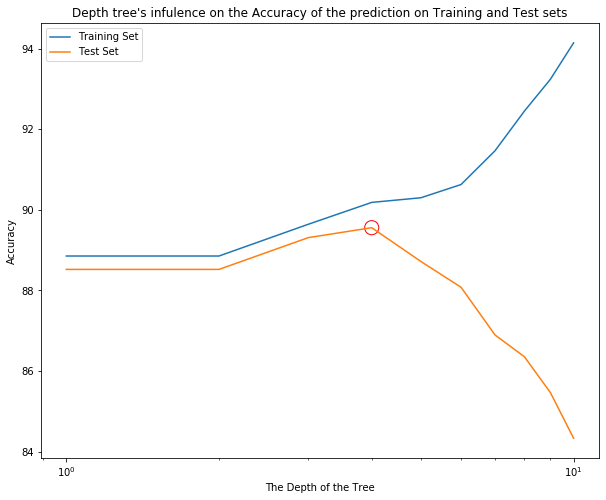

In [18]:
#### Your code here ####
depths_range = range(1,11) # range of depths to check
accuracy_train_list = list() #list of accuracy in the train set
accuracy_test_list = list() #list of accuracy in the test set
best_accuracy_train, best_accuracy_test = 0, 0 #best accuracy in the train set and test set respectivly
best_depth_train, best_depth_test = 0,0 #depth of best accuracy in the train set and test set respectivly

for depth in depths_range:
    #build the tree for each depth and calcualte the accuracy for both test and train sets 
    tree = build_tree(data=X_train, impurity=calc_entropy,gain_ratio=True,max_depth=depth)
    accuracy_train = (calc_accuracy(tree,X_train))
    accuracy_test = (calc_accuracy(tree,X_test))
    
    #append the accuracy to each list
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)
    
    #check for best accuracy in train set
    if accuracy_train > best_accuracy_train:
        best_accuracy_train = accuracy_train 
        best_depth_train = depth
    
    #check for best accuracy in test set
    if accuracy_test > best_accuracy_test:
        best_accuracy_test = accuracy_test 
        best_depth_test = depth

#plot the graph
plt.scatter(best_depth_test, best_accuracy_test,s=200, color='None',edgecolor = 'red')
plt.plot(list(depths_range), accuracy_train_list, label = 'Training Set')
plt.plot(list(depths_range), accuracy_test_list, label = 'Test Set')
plt.xscale('log')
plt.xlabel('The Depth of the Tree')
plt.ylabel('Accuracy')
plt.title("Depth tree's infulence on the Accuracy of the prediction on Training and Test sets")
plt.legend()
plt.show()  

## Chi square pre-pruning

(15 points)

Consider the following p-value cut-off values: [1 (no pruning), 0.5, 0.25, 0.1, 0.05, 0.0001 (max pruning)]. For each value, construct a tree and prune it according to the cut-off value. Next, calculate the training and testing accuracy. <br>
On a single plot, draw the training and testing accuracy as a function of the tuple (p-value, tree depth). Mark the best result on the graph with red circle.

In [19]:
### Chi square table values ###
# The first key is the degree of freedom 
# The second key is the p-value cut-off
# The values are the chi-statistic that you need to use in the pruning
chi_table = {1: {0.5 : 0.45,
                 0.25 : 1.32,
                 0.1 : 2.71,
                 0.05 : 3.84,
                 0.0001 : 100000},
             2: {0.5 : 1.39,
                 0.25 : 2.77,
                 0.1 : 4.60,
                 0.05 : 5.99,
                 0.0001 : 100000},
             3: {0.5 : 2.37,
                 0.25 : 4.11,
                 0.1 : 6.25,
                 0.05 : 7.82,
                 0.0001 : 100000},
             4: {0.5 : 3.36,
                 0.25 : 5.38,
                 0.1 : 7.78,
                 0.05 : 9.49,
                 0.0001 : 100000},
             5: {0.5 : 4.35,
                 0.25 : 6.63,
                 0.1 : 9.24,
                 0.05 : 11.07,
                 0.0001 : 100000},
             6: {0.5 : 5.35,
                 0.25 : 7.84,
                 0.1 : 10.64,
                 0.05 : 12.59,
                 0.0001 : 100000},
             7: {0.5 : 6.35,
                 0.25 : 9.04,
                 0.1 : 12.01,
                 0.05 : 14.07,
                 0.0001 : 100000},
             8: {0.5 : 7.34,
                 0.25 : 10.22,
                 0.1 : 13.36,
                 0.05 : 15.51,
                 0.0001 : 100000},
             9: {0.5 : 8.34,
                 0.25 : 11.39,
                 0.1 : 14.68,
                 0.05 : 16.92,
                 0.0001 : 100000},
             10: {0.5 : 9.34,
                  0.25 : 12.55,
                  0.1 : 15.99,
                  0.05 : 18.31,
                  0.0001 : 100000},
             11: {0.5 : 10.34,
                  0.25 : 13.7,
                  0.1 : 17.27,
                  0.05 : 19.68,
                  0.0001 : 100000}}

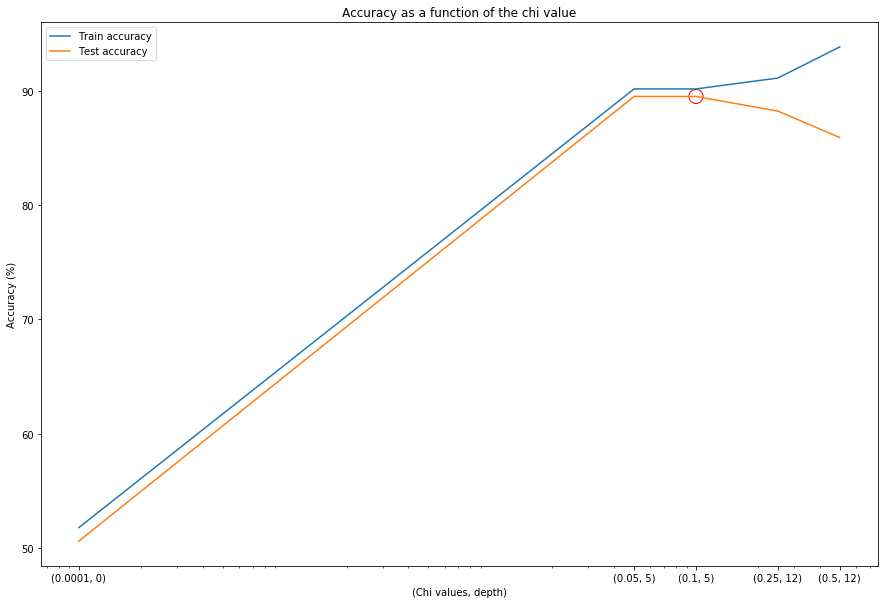

In [20]:
#### Your code here ####
cut_off_values = list(chi_table[1].keys()) # list of cut off values to check

accuracy_train_list = list()  #list of accuracy in the train set
accuracy_test_list = list() #list of accuracy in the test set
depth_list = list() #list of tree depths

best_accuracy_train, best_accuracy_test = 0, 0 #best of accuracy in the train set and test set respectivly
best_chi_train, best_chi_test=0, 0 #chi of best accuracy in the train set and test set respectivly
best_depth_chi_train, best_depth_chi_test=0, 0 #depth of best accuracy in the train set and test set respectivly


for chi in cut_off_values:
    #build the tree for each cut of value and calcualte the accuracy for both test and train sets 
    tree = build_tree(data=X_train, impurity=calc_entropy,gain_ratio=True,chi=chi)
    accuracy_train = (calc_accuracy(tree,X_train))
    accuracy_test = (calc_accuracy(tree,X_test))

    #append the tree's depth to the list
    depth_list.append(str(tuple([chi,tree.max_depth])))

    #append the accuracy to each list
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)
    
    #check for best accuracy in train set
    if(accuracy_train > best_accuracy_train):
        best_accuracy_train = accuracy_train 
        best_depth_train = tree.max_depth
        best_depth_chi_train = chi
        
    #check for best accuracy in test set
    if(accuracy_test > best_accuracy_test):
        best_accuracy_test = accuracy_test 
        best_depth_chi_test = tree.max_depth
        best_chi_test = chi
        

#plot the graph
plt.figure(figsize=(15, 10))
plt.xscale('log')
plt.xticks(cut_off_values, depth_list)
plt.plot(cut_off_values, accuracy_train_list)
plt.plot(cut_off_values, accuracy_test_list)
plt.scatter(best_chi_test, best_accuracy_test, s=200, color='None',edgecolor = 'red')
plt.xlabel('(Chi values, depth)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy as a function of the chi value')
plt.legend(['Train accuracy', 'Test accuracy']);
plt.show()

Build the best 2 trees:
1. tree_max_depth - the best tree according to max_depth pruning
1. tree_chi - the best tree according to chi square pruning

In [21]:
#### Your code here ####
tree_max_depth  =  build_tree(data=X_train, impurity=calc_entropy,gain_ratio=True,max_depth=best_depth_test)
tree_chi =  build_tree(data=X_train, impurity=calc_entropy,gain_ratio=True,chi=best_chi_test)

## Number of Nodes

(5 points) 

Of the two trees above we will choose the one with fewer nodes.

Complete the function counts_nodes and print the number of nodes in each tree

In [22]:
def count_nodes(node):
    """
    Count the number of node in a given tree
 
    Input:
    - node: a node in the decision tree.
 
    Output: the number of node in the tree.
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    return node.nodes_count
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    

## Print the tree

(5 points)

Complete the function `print_tree` and execute it on your chosen tree. Your code should do print:
```
[ROOT, feature=X0],
  [X0=a, feature=X2]
    [X2=c, leaf]: [{1.0: 10}]
    [X2=d, leaf]: [{0.0: 10}]
  [X0=y, feature=X5], 
       [X5=a, leaf]: [{1.0: 5}]
       [X5=s, leaf]: [{0.0: 10}]
  [X0=e, leaf]: [{0.0: 25, 1.0: 50}]
```
In each brackets:
* The first argument is the parent feature with the value that led to current node
* The second argument is the selected feature of the current node
* If the current node is a leaf, you need to print also the labels and their counts

In [23]:
# you can change the function signeture
def print_tree(node, depth=0, parent_feature='ROOT', feature_val='ROOT'):
    '''
    prints the tree according to the example above

    Input:
    - node: a node in the decision tree

    This function has no return value
    '''

    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    print(node)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
print_tree(tree_max_depth)

UnboundLocalError: local variable 'res' referenced before assignment